# Plot comparison of costs of restricted and open designs, and resulting VoO estimate convergence

In [1]:
# Hack to emulate running notebook from root directory.
import os
os.chdir('..')

In [2]:
import yaml
import numpy as np
import itertools

from configs import get_experiment_config

from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

#### Load design results for selected experiment

In [3]:
expt_name = 'base'

In [4]:
settings, base_params = get_experiment_config(expt_name)
available_technologies = list(settings['probability_settings']['storage'].keys())
tech_combos = list(itertools.combinations(available_technologies, settings['model_settings']['N_technologies']))
tech_combos_strs = ['-'.join(t) for t in tech_combos]
N = settings['probability_settings']['n_prior_samples']

In [5]:
if settings['model_settings']['N_technologies'] == 2:
    colors = list(plt.cm.Dark2.colors)
else:
    colors = list(plt.cm.tab10.colors)

In [6]:
none_results = yaml.safe_load(open(os.path.join(*settings['results_dir'],'prior','none_design.yaml')))
prior_design_results_files = [os.path.join(*settings['results_dir'],'prior',f'{techs}_design.yaml') for techs in tech_combos_strs]
prior_results = [yaml.safe_load(open(f)) for f in prior_design_results_files]
prior_opt_results = yaml.safe_load(open(os.path.join(*settings['results_dir'],'prior','best_design.yaml')))

result_dir_path_pattern = os.path.join(*settings['results_dir'],'posterior','z_scenario_{z}')

open_design_results_files = [os.path.join(result_dir_path_pattern.format(z=z),'open_design.yaml') for z in range(N)]
open_results = [yaml.safe_load(open(f)) for f in open_design_results_files]
restricted_design_results_files = [os.path.join(result_dir_path_pattern.format(z=z),'restricted_design.yaml') for z in range(N)]
restricted_results = [yaml.safe_load(open(f)) for f in restricted_design_results_files]

Note: comment on cost reduction from adding storage. (Compare cost to none design case)

Despite a very small proportion of the budget being spent on storage, it really reduces the cost!

A small amount of storage gives great returns on capital!

Quick bit of pre-analysis

In [7]:
# Load cost data
no_storage_cost = none_results['overall_objective']['overall_objective']
prior_cost = prior_opt_results['overall_objective']['overall_objective']
prior_techs = prior_opt_results['design']['storage_technologies']
restricted_expected_cost = np.mean([res['overall_objective']['overall_objective'] for res in restricted_results])
open_expected_cost = np.mean([res['overall_objective']['overall_objective'] for res in open_results])

for i, techs in enumerate(tech_combos_strs):
    print(f'{techs}: {prior_results[i]["overall_objective"]["overall_objective"]/1e6:.2f} €m/yr')
print('')

print(f'No storage cost: {no_storage_cost/1e6:.2f} €m/yr')
print(f'Prior cost: {prior_cost/1e6:.2f} €m/yr, {prior_techs}')
print(f'Open expected cost: {open_expected_cost/1e6:.2f} €m/yr')
print(f'Restricted expected cost: {restricted_expected_cost/1e6:.2f} €m/yr')

CAES: 148.11 €m/yr
Li-ion: 150.15 €m/yr
NaS: 124.12 €m/yr
VRBF: 176.59 €m/yr

No storage cost: 183.68 €m/yr
Prior cost: 124.12 €m/yr, ['NaS']
Open expected cost: 97.53 €m/yr
Restricted expected cost: 110.36 €m/yr


In [8]:
# Compute cost differences
print(f'Storage benefit: {(no_storage_cost - prior_cost)/1e6:.2f} €m/yr')
storage_cost = prior_opt_results['overall_objective']['overall_storage_cost']
print(f'Storage cost: {storage_cost/1e6:.2f} €m/yr')
print('')
print(f'VoI: {(prior_cost - restricted_expected_cost)/1e6:.2f} €m/yr')
print(f'VoO: {(restricted_expected_cost - open_expected_cost)/1e6:.2f} €m/yr')

Storage benefit: 59.56 €m/yr
Storage cost: 10.75 €m/yr

VoI: 13.76 €m/yr
VoO: 12.82 €m/yr


In [9]:
# Compute associated carbon savings
carbon_cost = base_params['cost_values']['carbon_price']
no_storage_carbon = none_results['overall_objective']['overall_carbon_cost']
prior_carbon = prior_opt_results['overall_objective']['overall_carbon_cost']
restricted_expected_carbon = np.mean([res['overall_objective']['overall_carbon_cost'] for res in restricted_results])
open_expected_carbon = np.mean([res['overall_objective']['overall_carbon_cost'] for res in open_results])

print(f'Storage carbon benefit: {(no_storage_carbon - prior_carbon)/(carbon_cost*1e3):.0f} tCO2/yr')
print(f'Unc. red. carbon benefit: {(prior_carbon - restricted_expected_carbon)/(carbon_cost*1e3):.0f} tCO2/yr')
print(f'Optionality carbon benefit: {(restricted_expected_carbon - open_expected_carbon)/(carbon_cost*1e3):.0f} tCO2/yr')

Storage carbon benefit: 20901 tCO2/yr
Unc. red. carbon benefit: 2002 tCO2/yr
Optionality carbon benefit: 646 tCO2/yr


In [10]:
# Look at frequency of posterior optimal storage technologies
techs = ['-'.join(res['design']['storage_technologies']) for res in open_results]
counts = Counter(techs)
print(dict(counts))

{'NaS': 122, 'Li-ion': 120, 'VRBF': 4, 'CAES': 4}


#### Plot cost distributions

CAES: 138.41 €m/yr
Li-ion: 112.88 €m/yr
NaS: 110.36 €m/yr
VRBF: 154.94 €m/yr


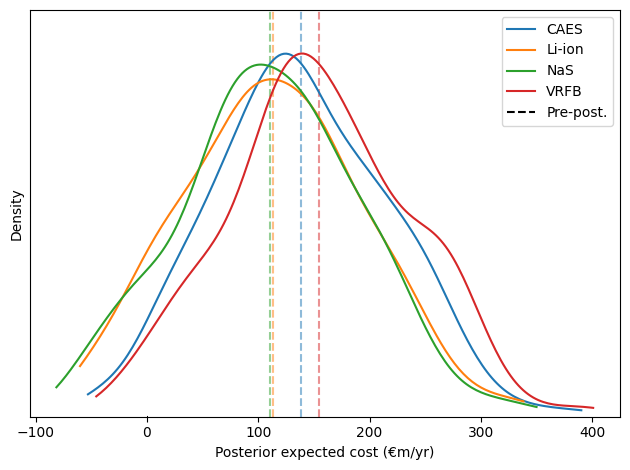

In [11]:
fig,ax = plt.subplots()

plt.ylim(0,5.5e-3)

for techs_str in tech_combos_strs:
    design_results_files = [os.path.join(result_dir_path_pattern.format(z=z),'design_options',f'{techs_str}_design.yaml') for z in range(N)]
    design_results = [yaml.safe_load(open(f)) for f in design_results_files]
    post_costs = np.array([res['overall_objective']['overall_objective'] for res in design_results])
    print(f"{techs_str}: {np.mean(post_costs)/1e6:.2f} €m/yr")

    c = colors[tech_combos_strs.index(techs_str)]

    sns.kdeplot(
        post_costs/1e6,
        ax=ax,
        label='VRFB' if techs_str=='VRBF' else techs_str,
        color=c,
        cut=0
    )
    plt.vlines(
        np.mean(post_costs)/1e6,
        0,
        ax.get_ylim()[1],
        color=c,
        linestyle="--",
        alpha=0.5,
        zorder=1
    )

plt.yticks([])
plt.xlabel('Posterior expected cost (€m/yr)')

plt.hlines(0,0,1,color='black',linestyles=['--'],label='Pre-post.')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join('plots',f'{expt_name}_post_cost_dists.pdf'))
plt.show()

Note that these pre-posterior costs are much lower than the prior costs - as expected because the system design is done with reduced uncertainty (important for budget constraint), so there is some VoI. But the interesting thing here is that given the problem structure, just doing the prior analysis leads to a significant over-estimate of expected costs! (Important for planning/financing)

This actually motivates the way of making decisions this way (i.e. adjusting capacities after R&D, cost improvement is pretty big - quantify & discuss).

#### Plot designs

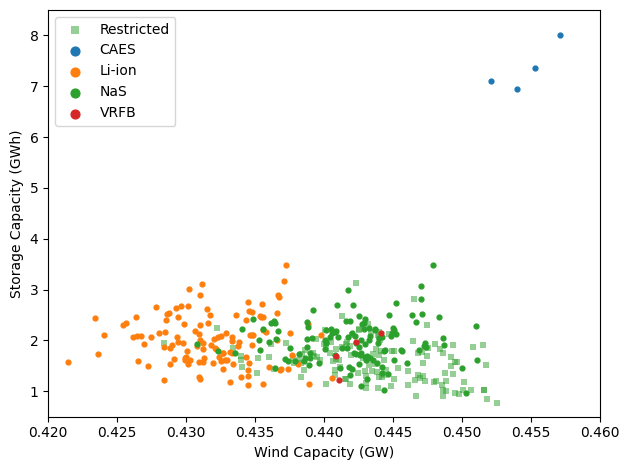

In [12]:
fig, ax = plt.subplots()

restricted_techs = restricted_results[0]['design']['storage_technologies']
restricted_techs_str = '-'.join(restricted_techs)
restricted_wind_caps = np.array([])
restricted_storage_caps = np.array([])

for res in restricted_results:
    restricted_wind_caps = np.append(restricted_wind_caps,res['design']['wind_capacity']['value'])
    total_storage_cap = 0
    for tech in restricted_techs:
        total_storage_cap += res['design']['storage_capacities'][tech]['value']
    restricted_storage_caps = np.append(restricted_storage_caps,total_storage_cap)

open_wind_caps = np.array([])
open_techs = np.array([])
open_storage_caps = np.array([])

for res in open_results:
    open_wind_caps = np.append(open_wind_caps,res['design']['wind_capacity']['value'])
    techs = res['design']['storage_technologies']
    open_techs = np.append(open_techs,'-'.join(techs))
    total_storage_cap = 0
    for tech in techs:
        total_storage_cap += res['design']['storage_capacities'][tech]['value']
    open_storage_caps = np.append(open_storage_caps,total_storage_cap)

ax.scatter(
    x=restricted_wind_caps[open_techs != restricted_techs_str]/1e6,
    y=restricted_storage_caps[open_techs != restricted_techs_str]/1e6,
    c=[colors[tech_combos_strs.index(restricted_techs_str)]],
    alpha=0.5,
    lw=0,
    label='Restricted',
    marker='s',
    s=15
)

for techs_str in tech_combos_strs:
    ax.scatter(
        x=open_wind_caps[open_techs == techs_str]/1e6,
        y=open_storage_caps[open_techs == techs_str]/1e6,
        c=[colors[tech_combos_strs.index(techs_str)]],
        label='VRFB' if techs_str=='VRBF' else techs_str,
        s=12
    )

plt.xlim(0.42,0.46)
plt.ylim(0.5,8.5)

plt.xlabel('Wind Capacity (GW)')
plt.ylabel('Storage Capacity (GWh)')

lgnd = plt.legend()
for i in range(len(tech_combos)+1):
    lgnd.legend_handles[i]._sizes = [40]

plt.tight_layout()
plt.savefig(os.path.join('plots',f'{expt_name}_post_designs.pdf'))
plt.show()

#### Plot improvement in cost from open design c.f. restricted

In [13]:
open_costs = np.array([])
restricted_costs = np.array([])
open_techs = np.array([])

for i in range(N):
    open_costs = np.append(open_costs,open_results[i]['overall_objective']['overall_objective'])
    restricted_costs = np.append(restricted_costs,restricted_results[i]['overall_objective']['overall_objective'])
    open_techs = np.append(open_techs,'-'.join(open_results[i]['design']['storage_technologies']))

cost_improvements = restricted_costs - open_costs

voi_estimates = np.array([np.mean(cost_improvements[:i+1]) for i in range(N)])
voi_std_errors = np.array([np.std(cost_improvements[:i+1])/np.sqrt(i+1) for i in range(N)])

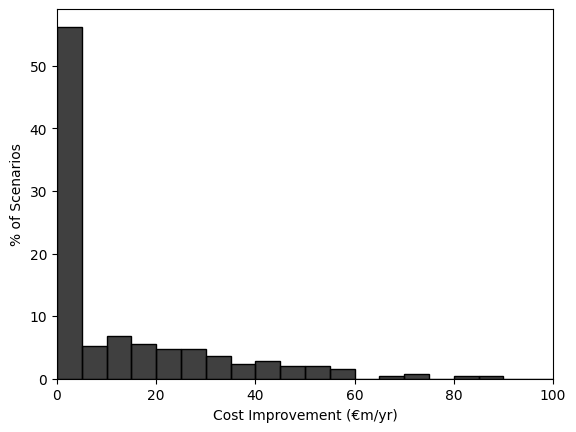

In [14]:
# plot cost comparison open vs restricted case
fig, ax = plt.subplots()

sns.histplot(
    cost_improvements/1e6,
    binrange=(0,100),
    binwidth=5,
    stat='percent',
    ax=ax,
    color='black'
)

plt.xlim(0,100)

plt.xlabel('Cost Improvement (€m/yr)')
plt.ylabel('% of Scenarios')

plt.show()

/var/folders/_w/yysl2wsx45l9qs06_sdm91sh0000gn/T/ipykernel_5451/1001021086.py:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


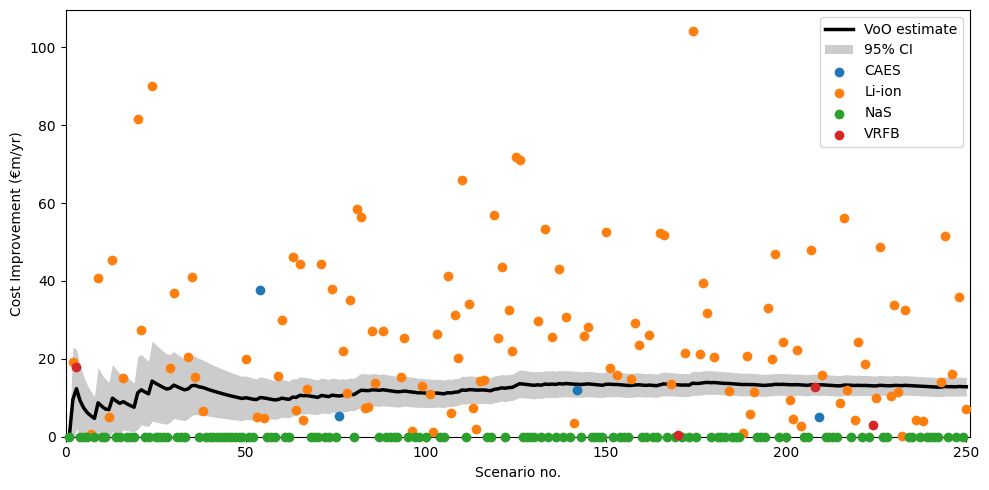

In [15]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(
    np.arange(1,N+1),
    voi_estimates/1e6,
    label='VoO estimate',
    color='black',
    lw=2.5,
    zorder=1
)
ax.fill_between(
    np.arange(1,N+1),
    (voi_estimates - 2*voi_std_errors)/1e6,
    (voi_estimates + 2*voi_std_errors)/1e6,
    label='95% CI',
    color='black',
    lw=0,
    alpha=0.2,
    zorder=0
)

for techs_str in tech_combos_strs:
    ax.scatter(
        x=np.arange(1,N+1)[open_techs == techs_str],
        y=cost_improvements[open_techs == techs_str]/1e6,
        c = colors[tech_combos_strs.index(techs_str)],
        label='VRFB' if techs_str=='VRBF' else techs_str,
        clip_on=False,
        zorder=100
    )

plt.xlim(0,N+1)
plt.ylim(0)

plt.xlabel('Scenario no.')
plt.ylabel('Cost Improvement (€m/yr)')

plt.legend()
plt.tight_layout()
plt.savefig(os.path.join('plots',f'{expt_name}_designs_comparison.pdf'))
plt.show()

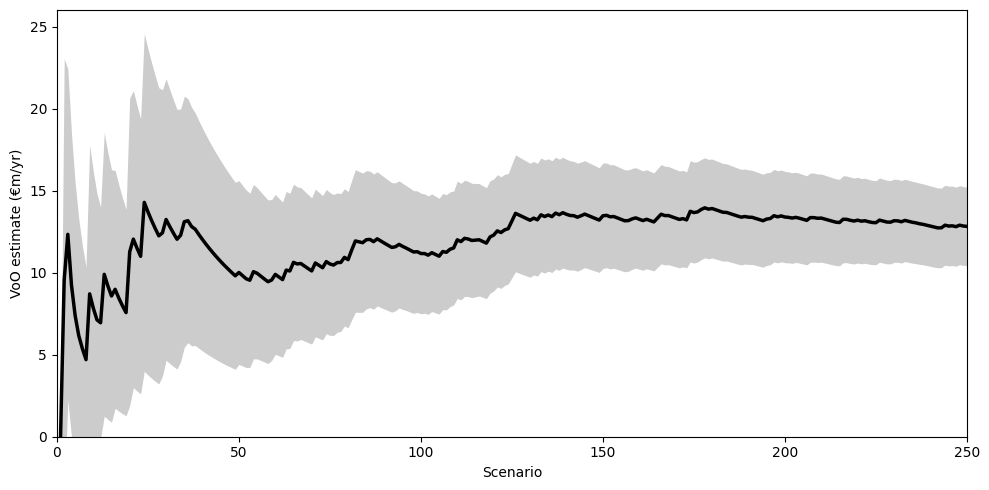

In [16]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(
    np.arange(1,N+1),
    voi_estimates/1e6,
    color='black',
    lw=2.5,
    zorder=1
)
ax.fill_between(
    np.arange(1,N+1),
    (voi_estimates - 2*voi_std_errors)/1e6,
    (voi_estimates + 2*voi_std_errors)/1e6,
    color='black',
    lw=0,
    alpha=0.2,
    zorder=0
)

plt.xlim(0,N)
plt.ylim(0)

plt.xlabel('Scenario')
plt.ylabel('VoO estimate (€m/yr)')
plt.tight_layout()
plt.savefig(os.path.join('plots',f'{expt_name}_voo_conv.pdf'))
plt.show()

Plot scenarios ordered by cost improvement

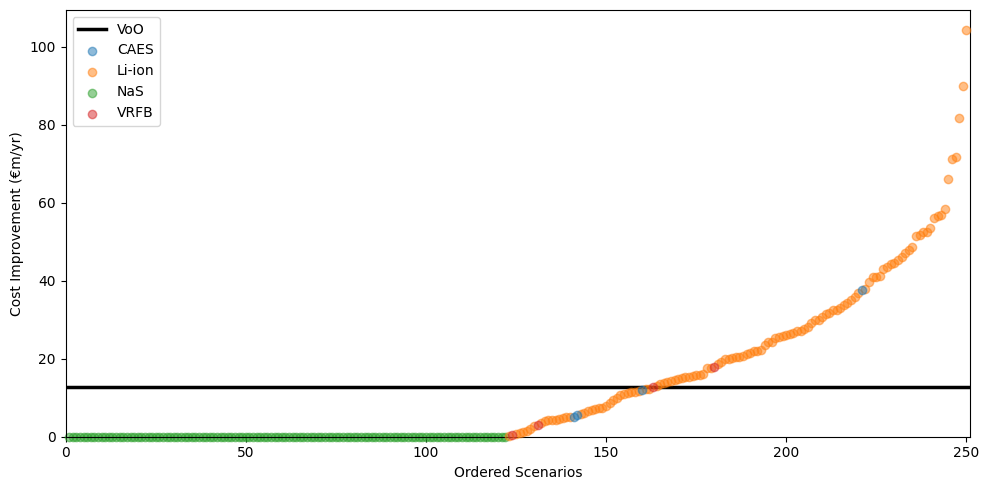

In [17]:
ordered_cost_improvements = cost_improvements[np.argsort(cost_improvements)]
ordered_open_techs = open_techs[np.argsort(cost_improvements)]
zorders = [10,5,2,8]

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(
    np.arange(0,N+2),
    np.ones(N+2)*np.mean(ordered_cost_improvements)/1e6,
    label='VoO',
    color='black',
    lw=2.5,
    zorder=1
)
for techs_str in tech_combos_strs:
    ax.scatter(
        x=np.arange(1,N+1)[ordered_open_techs == techs_str],
        y=ordered_cost_improvements[ordered_open_techs == techs_str]/1e6,
        c=[colors[tech_combos_strs.index(techs_str)]],
        alpha=0.5,
        label='VRFB' if techs_str=='VRBF' else techs_str,
        clip_on=False,
        zorder=zorders[tech_combos_strs.index(techs_str)]
    )

plt.xlim(0,N+1)
plt.ylim(0)

plt.xlabel('Ordered Scenarios')
plt.ylabel(r'Cost Improvement (€m/yr)')

plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join('plots',f'{expt_name}_ordered_design_comparison.pdf'))
plt.show()